In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
from scipy.special import softmax

In [ ]:


env = gym.make('CartPole-v1')

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")
state = env.reset()
print(state)
print("----")
action = env.action_space.sample()
print(action)
print("----")
next_state, reward, done, info = env.step(action)
print(next_state)
print(reward)
print(done)
print(info)
print("----")


4
2
1
----
[ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
1
----
[ 0.01323574  0.17272775 -0.04686959 -0.3551522 ]
1.0
False
{}
----


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F


BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 30       # how often to update the network (When Q target is present)


class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1_value = nn.Linear(state_size, fc1_units)
        self.fc2_value = nn.Linear(fc1_units, fc2_units)
        self.fc3_value = nn.Linear(fc2_units, 1)  # Output layer for value stream

        self.fc1_advantage = nn.Linear(state_size, fc1_units)
        self.fc2_advantage = nn.Linear(fc1_units, fc2_units)
        self.fc3_advantage = nn.Linear(fc2_units, action_size)  # Output layer for advantage stream

    def forward(self, state):
        x_value = F.relu(self.fc1_value(state))
        x_value = F.relu(self.fc2_value(x_value))
        value = self.fc3_value(x_value)

        x_advantage = F.relu(self.fc1_advantage(state))
        x_advantage = F.relu(self.fc2_advantage(x_advantage))
        advantage = self.fc3_advantage(x_advantage)

        # Combine value and advantage streams to get Q-values using Dueling DQN formula
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return q_values


In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:


    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
class DuelingTutorialAgent():
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

'
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=1.0):


        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()



        probabilities = softmax(action_values.cpu().data.numpy().flatten()/eps)
        return random.choices(population=range(len(probabilities)), weights=probabilities, k=1)[0]


    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)


        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)


        self.optimizer.zero_grad()
        loss.backward()

        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

In [ ]:


state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def ddqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    all_scores = []
    scores_window = deque(maxlen=100)


    eps = eps_start


    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        all_scores.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return all_scores



' Trial run to check if algorithm runs and saves the data '

In [ ]:
all_scores_type1 = []
seeds = [10, 18, 36, 42, 85]
for i in seeds:
  begin_time = datetime.datetime.now()
  env.reset()
  env.seed(i)
  agent = DuelingTutorialAgent(state_size=state_shape,action_size = action_shape,seed = i)
  all_scores = ddqn()
  all_scores_type1.append(all_scores)




Episode 100	Average Score: 189.41
Episode 106	Average Score: 202.14
Environment solved in 106 episodes!	Average Score: 202.14
Episode 62	Average Score: 202.94
Environment solved in 62 episodes!	Average Score: 202.94
Episode 100	Average Score: 127.39
Episode 174	Average Score: 200.87
Environment solved in 174 episodes!	Average Score: 200.87
Episode 100	Average Score: 174.49
Episode 112	Average Score: 200.82
Environment solved in 112 episodes!	Average Score: 200.82
Episode 89	Average Score: 203.20
Environment solved in 89 episodes!	Average Score: 203.20


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(all_scores_type1[0], label='Episode Scores')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('DQN Training Progress')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 30       # how often to update the network (When Q target is present)


class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1_value = nn.Linear(state_size, fc1_units)
        self.fc2_value = nn.Linear(fc1_units, fc2_units)
        self.fc3_value = nn.Linear(fc2_units, 1)  # Output layer for value stream

        self.fc1_advantage = nn.Linear(state_size, fc1_units)
        self.fc2_advantage = nn.Linear(fc1_units, fc2_units)
        self.fc3_advantage = nn.Linear(fc2_units, action_size)  # Output layer for advantage stream

    def forward(self, state):
      x_value = F.relu(self.fc1_value(state))
      x_value = F.relu(self.fc2_value(x_value))
      value = self.fc3_value(x_value)
      x_advantage = F.relu(self.fc1_advantage(state))
      x_advantage = F.relu(self.fc2_advantage(x_advantage))
      advantage = self.fc3_advantage(x_advantage)

      # Combine value and advantage streams to get Q-values using Dueling DQN Type-2 formula
      q_values = value + (advantage - advantage.max(dim=1, keepdim=True)[0])

      return q_values

In [ ]:
all_scores_type2 = []
seeds = [10, 18, 36, 42, 85]
for i in seeds:
  begin_time = datetime.datetime.now()
  env.reset()
  env.seed(i)
  agent = DuelingTutorialAgent(state_size=state_shape,action_size = action_shape,seed = i)
  all_scores = ddqn()
  all_scores_type2.append(all_scores)

Episode 59	Average Score: 200.02
Environment solved in 59 episodes!	Average Score: 200.02
Episode 100	Average Score: 195.79
Episode 102	Average Score: 201.77
Environment solved in 102 episodes!	Average Score: 201.77
Episode 95	Average Score: 201.65
Environment solved in 95 episodes!	Average Score: 201.65
Episode 73	Average Score: 200.07
Environment solved in 73 episodes!	Average Score: 200.07
Episode 61	Average Score: 201.33
Environment solved in 61 episodes!	Average Score: 201.33


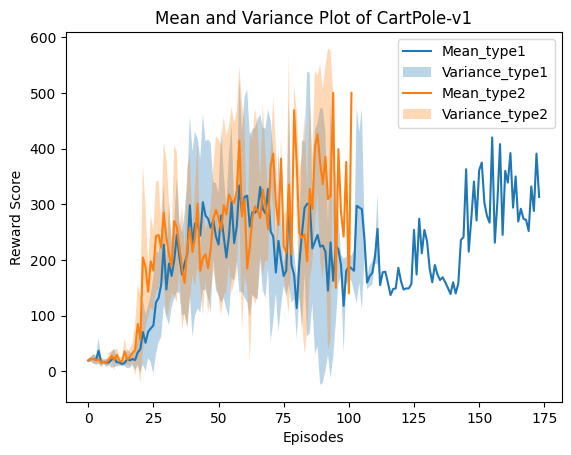

In [ ]:
mean_list1 = []
variance_list1 = []

for i in range(max(len(lst) for lst in all_scores_type1)):
    numbers = []
    for lst in all_scores_type1:
        if i < len(lst):
            numbers.append(lst[i])
    if len(numbers) > 1:  # Check if there are at least two elements
        mean = sum(numbers) / len(numbers)
        variance = statistics.variance(numbers)
        mean_list1.append(mean)
        variance_list1.append(variance)
    elif len(numbers) == 1:  # If there's only one element, set variance to 0
        mean_list1.append(numbers[0])
        variance_list1.append(0)

# Plotting
x = range(len(mean_list1))
plt.plot(x, mean_list1, label='Mean_type1')
plt.fill_between(x, [m - v ** 0.5 for m, v in zip(mean_list1, variance_list1)],
                 [m + v ** 0.5 for m, v in zip(mean_list1, variance_list1)],
                 alpha=0.3, label='Variance_type1')





mean_list2 = []
variance_list2 = []

for i in range(max(len(lst) for lst in all_scores_type2)):
    numbers = []
    for lst in all_scores_type2:
        if i < len(lst):
            numbers.append(lst[i])
    if len(numbers) > 1:  # Check if there are at least two elements
        mean = sum(numbers) / len(numbers)
        variance = statistics.variance(numbers)
        mean_list2.append(mean)
        variance_list2.append(variance)
    elif len(numbers) == 1:  # If there's only one element, set variance to 0
        mean_list2.append(numbers[0])
        variance_list2.append(0)

# Plotting
x = range(len(mean_list2))
plt.plot(x, mean_list2, label='Mean_type2')
plt.fill_between(x, [m - v ** 0.5 for m, v in zip(mean_list2, variance_list2)],
                 [m + v ** 0.5 for m, v in zip(mean_list2, variance_list2)],
                 alpha=0.3, label='Variance_type2')
plt.xlabel('Episodes')
plt.ylabel('Reward Score')
plt.title('Mean and Variance Plot of CartPole-v1')
plt.legend()
plt.show()